In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [3]:
import os

data_path = "../data"
audio_files = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith(".wav")]

print(audio_files[1:5])


['../data\\AH_545622717-461DFFFE-54AF-42AF-BA78-528BD505D624.wav', '../data\\AH_545622718-C052AD58-5E6B-4ADC-855C-F76B66BAFA6E.wav', '../data\\AH_545622719-52C23861-6E0D-41E0-A3D8-9358C28C019B.wav', '../data\\AH_545622720-E1486AF6-8C95-47EB-829B-4D62698C987A.wav']


In [4]:
print("Total files:", len(audio_files))
print(audio_files)


Total files: 36
['../data\\AH_545616858-3A749CBC-3FEB-4D35-820E-E45C3E5B9B6A.wav', '../data\\AH_545622717-461DFFFE-54AF-42AF-BA78-528BD505D624.wav', '../data\\AH_545622718-C052AD58-5E6B-4ADC-855C-F76B66BAFA6E.wav', '../data\\AH_545622719-52C23861-6E0D-41E0-A3D8-9358C28C019B.wav', '../data\\AH_545622720-E1486AF6-8C95-47EB-829B-4D62698C987A.wav', '../data\\AH_545622722-3C79DA68-36BB-43A2-B29C-61AEF480E07E.wav', '../data\\AH_545629296-C2C009C6-8C17-42EA-B6BE-362942FC4692.wav', '../data\\AH_545643618-82A143AC-B643-4273-A923-C42A83AEEC5F.wav', '../data\\AH_545648867-CB17D873-1CEA-492A-B5B0-93C7463F516C.wav', '../data\\AH_545692309-EA8C4DC0-9B2A-4CC7-A490-851A2129A733.wav', '../data\\AH_545692315-C2972597-9AEC-4060-A186-F1F59340640C.wav', '../data\\AH_545713221-1E77C030-4558-4A88-B1A2-6AB777ACAE61.wav', '../data\\AH_545713222-DA13DC3A-F24B-454E-984F-19DF19328D39.wav', '../data\\AH_545743929-E2EAE1A3-7E46-4DCF-8DB7-37A5CA47DB9D.wav', '../data\\AH_545753013-FCFF8F46-08FF-4C87-B443-D2039E5DA945

In [65]:
ipd.Audio(audio_files[20])

In [6]:
RAW_AUDIO, sample_rate = librosa.load(audio_files[0])
print(f'raw audio: {RAW_AUDIO[:10]}')
print(f'shape of raw audio: {RAW_AUDIO.shape}')
print(f'sample rate: {sample_rate}')

raw audio: [0.0051591  0.00707524 0.00783593 0.0086598  0.00849376 0.0074822
 0.006607   0.0064899  0.00691292 0.00691403]
shape of raw audio: (121008,)
sample rate: 22050


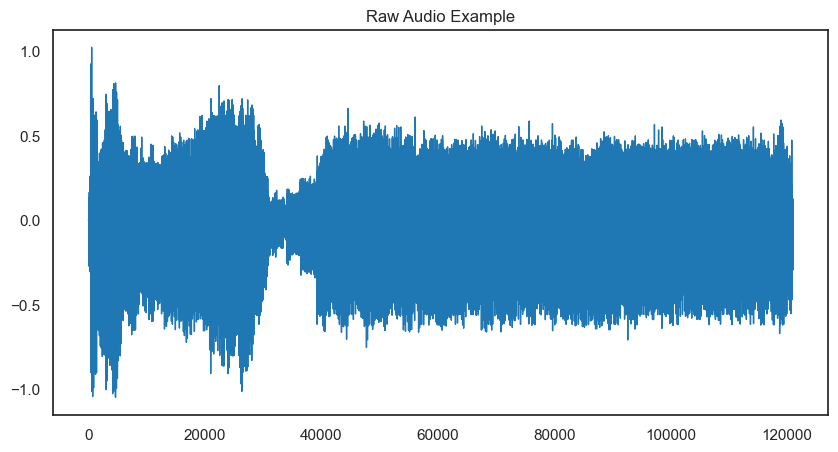

In [7]:
pd.Series(RAW_AUDIO).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example',
                 color=color_pal[0])
plt.show()

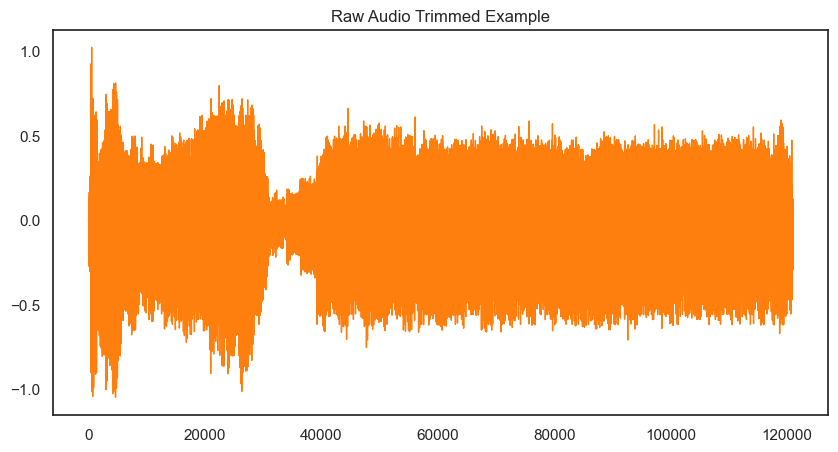

In [8]:
# Trimming leading/lagging silence
RAW_AUDIO_trimmed, _ = librosa.effects.trim(RAW_AUDIO, top_db=20)
pd.Series(RAW_AUDIO_trimmed).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Trimmed Example',
                 color=color_pal[1])
plt.show()

In [9]:
spectrogram = librosa.stft(RAW_AUDIO)
spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)
spectrogram_db.shape

(1025, 237)

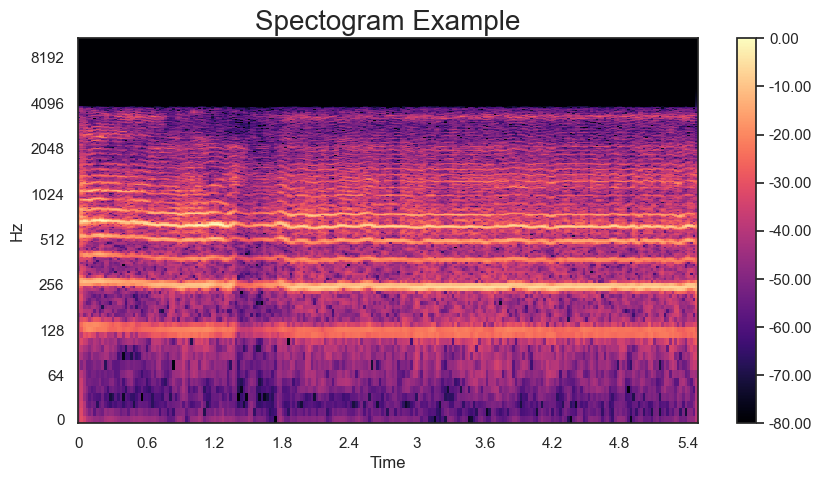

In [10]:
# Plot the transformed audio data
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(spectrogram_db,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [11]:
pip install praat-parselmouth


   ---------------------------------------- 0.0/9.0 MB ? eta -:--:--
   --- ------------------------------------ 0.8/9.0 MB 8.3 MB/s eta 0:00:01
   ------------------ --------------------- 4.2/9.0 MB 14.0 MB/s eta 0:00:01
   ------------------------------------- -- 8.4/9.0 MB 16.8 MB/s eta 0:00:01
   ---------------------------------------  8.9/9.0 MB 16.8 MB/s eta 0:00:01
   ---------------------------------------- 9.0/9.0 MB 9.9 MB/s  0:00:01
Note: you may need to restart the kernel to use updated packages.


the code below run a loop and extracts the features from the data folder 

In [59]:
import numpy as np
import librosa
import parselmouth
from scipy.stats import entropy
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors

# ---------------------------------------------
# Helper: DFA
# ---------------------------------------------
def compute_dfa(signal):

    signal = signal - np.mean(signal)
    cumulative = np.cumsum(signal)

    window_sizes = np.logspace(1, 3, num=10).astype(int)
    fluct = []

    for w in window_sizes:
        if w >= len(cumulative):
            continue

        segments = len(cumulative) // w
        rms = []

        for i in range(segments):
            segment = cumulative[i*w:(i+1)*w]
            x = np.arange(w).reshape(-1, 1)
            model = LinearRegression().fit(x, segment)
            trend = model.predict(x)
            rms.append(np.sqrt(np.mean((segment - trend)**2)))

        fluct.append(np.mean(rms))

    if len(fluct) < 2:
        return 0

    window_sizes = window_sizes[:len(fluct)]
    fluct = np.array(fluct)   # 🔥 IMPORTANT FIX

    coeffs = np.polyfit(np.log(window_sizes),
                        np.log(fluct + 1e-6), 1)

    return coeffs[0]


# ---------------------------------------------
# Helper: Correlation Dimension (D2 Approx)
# ---------------------------------------------
def compute_d2(signal):

    signal = signal.reshape(-1, 1)

    nbrs = NearestNeighbors(n_neighbors=5).fit(signal)
    distances, _ = nbrs.kneighbors(signal)

    radii = np.linspace(np.min(distances),
                        np.max(distances), 20)

    C = []

    for r in radii:
        C.append(np.mean(distances < r))

    if len(C) < 2:
        return 0

    radii = np.array(radii)
    C = np.array(C)

    coeffs = np.polyfit(np.log(radii + 1e-6),
                        np.log(C + 1e-6), 1)

    return coeffs[0]

# ---------------------------------------------
# MASTER FEATURE EXTRACTOR
# ---------------------------------------------
def extract_master_features(audio_path):

    try:
        # -------------------------------
        # Load Audio
        # -------------------------------
        y, sr = librosa.load(audio_path, sr=16000)
        y, _ = librosa.effects.trim(y)

        sound = parselmouth.Sound(audio_path)

        # -------------------------------
        # Pitch Features
        # -------------------------------
        pitch = sound.to_pitch(pitch_floor=75, pitch_ceiling=300)
        pitch_values = pitch.selected_array['frequency']
        pitch_values = pitch_values[pitch_values > 0]

        if len(pitch_values) == 0:
            pitch_mean = pitch_std = pitch_min = pitch_max = 0
        else:
            pitch_mean = np.mean(pitch_values)
            pitch_std = np.std(pitch_values)
            pitch_min = np.min(pitch_values)
            pitch_max = np.max(pitch_values)

        # -------------------------------
        # Harmonicity
        # -------------------------------
        harmonicity = sound.to_harmonicity_cc()
        hnr = parselmouth.praat.call(harmonicity, "Get mean", 0, 0)
        if hnr is None or np.isnan(hnr):
            hnr = 0.0
        nhr = 1 / (hnr + 1e-6)

        # -------------------------------
        # Energy
        # -------------------------------
        rms = librosa.feature.rms(y=y)[0]
        rms_mean = np.mean(rms)
        rms_std = np.std(rms)

        # -------------------------------
        # Spectral Features
        # -------------------------------
        centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
        zcr = librosa.feature.zero_crossing_rate(y)[0]

        centroid_mean = np.mean(centroid)
        bandwidth_mean = np.mean(bandwidth)
        rolloff_mean = np.mean(rolloff)
        zcr_mean = np.mean(zcr)

        # -------------------------------
        # MFCC Features
        # -------------------------------
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)

        # -------------------------------
        # Nonlinear Features
        # -------------------------------
        dfa = compute_dfa(y)
        d2 = compute_d2(y)

        if len(pitch_values) > 10:
            periods = 1 / pitch_values
            hist, _ = np.histogram(periods, bins=30, density=True)
            ppe = entropy(hist) if np.sum(hist) > 0 else 0
        else:
            ppe = 0

        spread1 = np.std(pitch_values) if len(pitch_values) > 0 else 0
        spread2 = np.var(pitch_values) if len(pitch_values) > 0 else 0

        hist, _ = np.histogram(y, bins=50, density=True)
        rpde = entropy(hist)

        # -------------------------------
        # Combine Everything
        # -------------------------------
        features = np.hstack([
            pitch_mean, pitch_std, pitch_min, pitch_max,
            hnr, nhr,
            rms_mean, rms_std,
            centroid_mean, bandwidth_mean, rolloff_mean, zcr_mean,
            mfcc_mean,
            mfcc_std,
            dfa,
            d2,
            ppe,
            spread1,
            spread2,
            rpde
        ])

        features = np.nan_to_num(features, nan=0.0)

        return features

    except Exception as e:
        print("Feature extraction failed:", e)
        return None


In [61]:
file_path = r"D:\PERKINSON DISEASE\data\your_file.wav"

features = extract_master_features(file_path)

print("Returned:", features)


Feature extraction failed: [Errno 2] No such file or directory: 'D:\\PERKINSON DISEASE\\data\\your_file.wav'
Returned: None


C:\Users\royom\AppData\Local\Temp\ipykernel_6776\2097146278.py:85: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=16000)


In [62]:
file_path = r"D:\PERKINSON DISEASE\data\AH_545616858-3A749CBC-3FEB-4D35-820E-E45C3E5B9B6A.wav"

features = extract_master_features(file_path)

print("Type:", type(features))
print("Is None?", features is None)

if features is not None:
    print("Feature count:", len(features))
    print("NaNs:", np.isnan(features).sum())
    print("Features:\n", features)
else:
    print("Features returned None.")


Type: <class 'numpy.ndarray'>
Is None? False
Feature count: 44
NaNs: 0
Features:
 [ 1.26353888e+02  3.37210151e+00  1.20319498e+02  1.37019936e+02
  1.36450930e+01  7.32864132e-02  2.29123101e-01  4.92606238e-02
  1.02405262e+03  8.37035059e+02  1.86664244e+03  8.24372048e-02
 -1.33069977e+02  1.92081512e+02 -8.98655930e+01  1.82852859e+01
 -2.37914124e+01 -2.72305717e+01  1.23004274e+01 -3.30502472e+01
  7.80560637e+00  7.35254097e+00 -1.17734833e+01  1.40064268e+01
 -2.50081081e+01  1.88948078e+01  9.93390274e+00  8.60792828e+00
  7.80568504e+00  9.38163185e+00  6.16067839e+00  9.62246704e+00
  8.52930450e+00  4.89340496e+00  4.96497726e+00  4.90759563e+00
  4.13730383e+00  4.46031618e+00  4.55000462e-01  1.15066320e+00
  2.98085112e+00  3.37210151e+00  1.13710686e+01  3.14104177e+00]


In [64]:
print(feature_names)

['filename', 'pitch_mean', 'pitch_std', 'pitch_min', 'pitch_max', 'hnr', 'rms_mean', 'rms_std', 'centroid_mean', 'bandwidth_mean', 'rolloff_mean', 'zcr_mean', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9', 'mfcc_mean_10', 'mfcc_mean_11', 'mfcc_mean_12', 'mfcc_mean_13', 'mfcc_std_1', 'mfcc_std_2', 'mfcc_std_3', 'mfcc_std_4', 'mfcc_std_5', 'mfcc_std_6', 'mfcc_std_7', 'mfcc_std_8', 'mfcc_std_9', 'mfcc_std_10', 'mfcc_std_11', 'mfcc_std_12', 'mfcc_std_13']
